# LSTM Series (working)

** - Matlab initialization strategy **

** - Train and Dev different loss functions **

** - Adam Optimizer **

_Train for imag part only_

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import math

import scipy.io as sio
import numpy as np
import h5py
import tensorflow as tf
import sys

import time

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"


from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import Dense, Activation, TimeDistributed
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Read parameters from .mat files
save in Opt object

In [2]:
Data_VERSION = "_e11v1"
Code_VERSION = "_e11v9-2"

In [3]:
DNN_DATA_FILE = "./dnn_models/DNN_datas"+ Data_VERSION+".mat"
# DNN_DATA_FILE = "./dnn_models/BR2_DNN_datas.mat"

DNN_MODEL_FILE = "./dnn_models/DNN_params"+ Data_VERSION+".mat"
# DNN_MODEL_FILE = "./dnn_models/BR2_DNN_params.mat"

DNN_NET_FILE = "./dnn_models/DNN_net"+ Code_VERSION+".mat"

MODEL_FILE = "./dnn_models/weights_{epoch:02d}"+ Code_VERSION+".h5"

SAVE_MODEL_FILE = "./dnn_models/py_model"+ Code_VERSION+".h5"

Files saved by Matlab reading class. Data, Parameters are read. 

In [4]:
class Opts:
    opts_dict = dict()

    def __init__(self, FILE, FILE_DATA):
        
        # Basic parameters
        with h5py.File(FILE, 'r') as f:
            key_list = list(f.keys())
            print('Opt key:',key_list)

            for k, v in f['opts'].items():

                print('key:', k)

                if k == 'ARMA_order':
                    self.ARMA_order = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.ARMA_order
                elif k == 'ada_grad_eps':
                    self.ada_grad_eps = np.array(v)[0][0]
                    self.opts_dict[k] = self.ada_grad_eps
                elif k == 'ada_sgd_scale':
                    self.ada_sgd_scale = np.array(v)[0][0]
                    self.opts_dict[k] = self.ada_sgd_scale
                elif k == 'change_momentum_point':
                    self.change_momentum_point = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.change_momentum_point
                elif k == 'cost_function':
                    self.cost_function = ""
                    for c in np.array(v):
                        self.cost_function += chr(c[0])

                    self.opts_dict[k] = self.cost_function

                elif k == 'cv_interval':
                    self.cv_interval = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.cv_interval
                elif k == 'dim_input':
                    self.dim_input = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.dim_input
                elif k == 'dim_output':
                    self.dim_output = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.dim_output
                elif k == 'drop_ratio':
                    self.drop_ratio = np.array(v)[0][0]
                    self.opts_dict[k] = self.drop_ratio
                elif k == 'eval_on_gpu':
                    self.eval_on_gpu = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.eval_on_gpu
                elif k == 'final_momentum':
                    self.final_momentum = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.final_momentum
                elif k == 'hid_struct':
                    self.hid_struct = np.array(v)
                    self.opts_dict[k] = self.hid_struct
                elif k == 'initial_momentum':
                    self.initial_momentum = np.array(v)[0][0]
                    self.opts_dict[k] = self.initial_momentum
                elif k == 'isDropout':
                    self.isDropout = 0
                    self.opts_dict[k] = self.isDropout
                elif k == 'isDropoutInput':
                    self.isDropoutInput = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.isDropoutInput
                elif k == 'isGPU':
                    self.isGPU = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.isGPU
                elif k == 'isNormalize':
                    self.isNormalize = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.isNormalize
                elif k == 'isPretrain':
                    self.isPretrain = int(np.array(v)[0][0])
                    self.opts_dict[k] = self.isPretrain
                elif k == 'learner':
                    self.learner = ""
                    for c in np.array(v):
                        self.learner += chr(c[0])

                    self.opts_dict[k] = self.learner

                elif k == 'net_struct':
                    self.net_struct = np.array(v)
                    for n_s in np.array(v):
                        print('Opts Net Stuct:',n_s[0])

                    self.opts_dict[k] = self.net_struct
                elif k == 'rbm_batch_size':
                    self.rbm_batch_size = int(np.array(v)[0][0])
                    print("self.rbm_batch_size:",self.rbm_batch_size)
                    # self.opts_dict[k] = self.rbm_batch_size
                elif k == 'rbm_learn_rate_binary':
                    self.rbm_learn_rate_binary = np.array(v)
                    # self.opts_dict[k] = self.rbm_learn_rate_binary
                elif k == 'rbm_learn_rate_real':
                    self.rbm_learn_rate_real = int(np.array(v)[0][0])
                    # self.opts_dict[k] = self.rbm_learn_rate_real
                elif k == 'rbm_max_epoch':
                    self.rbm_max_epoch = int(np.array(v)[0][0])
                    # self.opts_dict[k] = self.rbm_max_epoch
                elif k == 'save_on_fly':
                    self.save_on_fly = int(np.array(v)[0][0])
                    # self.opts_dict[k] = self.save_on_fly
                elif k == 'sgd_batch_size':
                    self.sgd_batch_size = int(np.array(v)[0][0])
                    print("self.sgd_batch_size:",self.sgd_batch_size)
#                     self.sgd_batch_size = 1024//2 # BATCH_SIZE for training net
                    # self.opts_dict[k] = self.sgd_batch_size
                elif k == 'sgd_learn_rate':
                    self.sgd_learn_rate = np.array(v)
                    # self.opts_dict[k] = self.sgd_learn_rate
                elif k == 'sgd_max_epoch':
                    self.sgd_max_epoch = int(np.array(v)[0][0])
                    # self.opts_dict[k] = self.sgd_max_epoch
                elif k == 'split_tanh1_c1':
                    self.split_tanh1_c1 = int(np.array(v)[0][0])
                    # self.opts_dict[k] = self.split_tanh1_c1
                elif k == 'split_tanh1_c2':
                    self.split_tanh1_c2 = int(np.array(v)[0][0])
                    # self.opts_dict[k] = self.split_tanh1_c2
                elif k == 'unit_type_hidden':
                    self.unit_type_hidden = ""
                    for c in np.array(v):
                        self.unit_type_hidden += chr(c[0])

                elif k == 'unit_type_output':
                    self.unit_type_output = ""
                    for c in np.array(v):
                        self.unit_type_output += chr(c[0])

        # Training and Dev Data 
        with h5py.File(FILE_DATA, 'r') as f:
            print('Opts h5py keys:', list(f.keys()))
            for k, v in f.items():

                if k == 'trData':
                    print("trData.shape: ", v.shape)
                    self.trData = np.transpose(np.array(v))
                    print("trData-> mean:", np.mean(self.trData), ", var:", np.var(self.trData), ", std:",
                          np.std(self.trData), ", range:", (np.amin(self.trData),np.amax(self.trData)))
                elif k == 'trLabel_i':
                    print("trLabel_i.shape: ", v.shape)
                    self.trLabel_i = np.transpose(np.array(v))
                    print("trLabel_i-> mean:", np.mean(self.trLabel_i), ", var:", np.var(self.trLabel_i), ", std:",
                          np.std(self.trLabel_i), ", range:", (np.amin(self.trLabel_i),np.amax(self.trLabel_i)))
                elif k == 'trLabel_r':
                    print("trLabel_r.shape: ", v.shape)
                    self.trLabel_r = np.transpose(np.array(v))
                    print("trLabel_r-> mean:", np.mean(self.trLabel_r), ", var:", np.var(self.trLabel_r), ", std:",
                          np.std(self.trLabel_r), ", range:", (np.amin(self.trLabel_r),np.amax(self.trLabel_r)))
                elif k == 'trNumframes':
                    print("trNumframes.shape: ", v.shape)
                    self.trNumframes = np.transpose(np.array(v))
                    
                elif k == 'cvData':
                    print("cvData.shape: ", v.shape)
                    self.cvData = np.transpose(np.array(v))
                    print("cvData-> mean:", np.mean(self.cvData), ", var:", np.var(self.cvData), ", std:",
                          np.std(self.cvData), ", range:", (np.amin(self.cvData),np.amax(self.cvData)))
                elif k == 'cvLabel_i':
                    print("cvLabel_i.shape: ", v.shape)
                    self.cvLabel_i = np.transpose(np.array(v))
                    print("cvLabel_i-> mean:", np.mean(self.cvLabel_i), ", var:", np.var(self.cvLabel_i), ", std:",
                          np.std(self.cvLabel_i), ", range:", (np.amin(self.cvLabel_i),np.amax(self.cvLabel_i)))
                elif k == 'cvLabel_r':
                    print("cvLabel_r.shape: ", v.shape)
                    self.cvLabel_r = np.transpose(np.array(v))
                    print("cvLabel_r-> mean:", np.mean(self.cvLabel_r), ", var:", np.var(self.cvLabel_r), ", std:",
                          np.std(self.cvLabel_r), ", range:", (np.amin(self.cvLabel_r),np.amax(self.cvLabel_r)))
                elif k == 'cvNumframes':
                    print("cvNumframes.shape: ", v.shape)
                    self.cvNumframes = np.transpose(np.array(v))

            self.trLabel = np.concatenate((self.trLabel_r, self.trLabel_i), axis=1)
            self.cvLabel = np.concatenate((self.cvLabel_r, self.cvLabel_i), axis=1)

    
    def prepare3D_data2(self, isTRAINING = True, typ='keras', maxlen=None):
        # TRAIN: total_num_samples = self.trData.shape[0] = 195192
        # DEV: total_num_samples = self.trData.shape[0] = 44961

        feat_vec_len = 1230
        out_vec_len = 963
        
        if isTRAINING:
            data = self.trData
            label_r = self.trLabel_r
            label_i = self.trLabel_i
            numframes = self.trNumframes
        else:
            data = self.cvData
            label_r = self.cvLabel_r
            label_i = self.cvLabel_i
            numframes = self.cvNumframes

        data3D, label3D_r, label3D_i = [], [], []
        numframes = np.cumsum(numframes)
        
        #### WORKING ON IT ...
        for e, frames in enumerate(numframes):
            frames= int(frames)
            pre_frames= int(numframes[e-1])
            
            d = data[:frames] if len(data3D)==0 else data[pre_frames:frames]
            r = label_r[:frames] if len(label3D_r)==0 else label_r[pre_frames:frames]
            i = label_i[:frames] if len(label3D_i)==0 else label_i[pre_frames:frames]
            
            if typ.lower() == 'keras':
                frames = d.shape[0]
                d = d.flatten()
                r = r.flatten()
                i = i.flatten()
                
            data3D.append( d )
            label3D_r.append( r )
            label3D_i.append( i )
            print("{0}: data3D.len={1}, label3D_r.len={2}, label3D_r.len={3}".format(e,len(data3D),len(label3D_r),len(label3D_r)))
            print("d:{0}, r:{1}, i:{2}".format(d.shape, r.shape, i.shape))
            return
        
        if typ.lower() == 'keras':
            maxlen = None if maxlen is None else maxlen*feat_vec_len
            data3D = pad_sequences(data3D, maxlen=maxlen, dtype='float', padding='post', truncating='post', value=0.0)
            
            maxlen = None if maxlen is None else maxlen*out_vec_len
            label3D_r = pad_sequences(label3D_r, maxlen=maxlen, dtype='float', padding='post', truncating='post', value=0.0)
            
            maxlen = None if maxlen is None else maxlen*out_vec_len
            label3D_i = pad_sequences(label3D_i, maxlen=maxlen, dtype='float', padding='post', truncating='post', value=0.0)
            
            print("# data3D.len={0}, label3D_r.len={1}, label3D_r.len={2}".format(data3D.shape,label3D_r.shape,label3D_r.shape))
            
            
            data3D = data3D.reshape(e,-1,feat_vec_len)
            label3D_r = label3D_r.flatten(e,-1,out_vec_len)
            label3D_i = label3D_i.flatten(e,-1,out_vec_len)
            
        print("## data3D.len={0}, label3D_r.len={1}, label3D_r.len={2}".format(data3D.shape,label3D_r.shape,label3D_r.shape))
                
            
        return data3D, label3D_r, label3D_i

    
    def prepare3D_list(self, isTRAINING = True):
        # TRAIN: total_num_samples = self.trData.shape[0] = 195192
        # DEV: total_num_samples = self.trData.shape[0] = 44961

        feat_vec_len = 1230
        out_vec_len = 963
        
        if isTRAINING:
            data = self.trData
            label_r = self.trLabel_r
            label_i = self.trLabel_i
            numframes = self.trNumframes
        else:
            data = self.cvData
            label_r = self.cvLabel_r
            label_i = self.cvLabel_i
            numframes = self.cvNumframes

        data3D, label3D_r, label3D_i = [], [], []
        numframes = np.cumsum(numframes)
        
        for e, frames in enumerate(numframes):
            frames= int(frames)
            pre_frames= int(numframes[e-1])
            
            d = data[:frames] if len(data3D)==0 else data[pre_frames:frames]
            r = label_r[:frames] if len(label3D_r)==0 else label_r[pre_frames:frames]
            i = label_i[:frames] if len(label3D_i)==0 else label_i[pre_frames:frames]
            
            data3D.append( d )
            label3D_r.append( r )
            label3D_i.append( i )

        return data3D, label3D_r, label3D_i

    def ready_batchID(self, total_num_samples, batch_size):
        # TRAIN: total_num_samples = self.trData.shape[0] = 195192
        # DEV: total_num_samples = self.trData.shape[0] = 44961

        batchID = []
        num_batch = math.ceil(total_num_samples/batch_size)

        for b in range( int(num_batch) ):
            s = b*batch_size
            e = (b+1)*batch_size -1

            if e >= total_num_samples:
                e = total_num_samples - 1

            batchID.append((s,e))

        return np.array(batchID,ndmin=2)


    def suffle_data(self, total_num_samples):
        # TRAIN: total_num_samples = self.trData.shape[0] = 195192
        # DEV: total_num_samples = self.trData.shape[0] = 44961

        return  np.random.permutation(total_num_samples)


    def next_batch(self, total_num_samples, batch_size, isTrainCycle=True):
        # TRAIN: total_num_samples = self.trData.shape[0] = 195192
        # DEV: total_num_samples = self.trData.shape[0] = 44961

        batchID = self.ready_batchID(total_num_samples, batch_size)
        seq = self.suffle_data(total_num_samples)

        for batch in range(batchID.shape[0]):
            if isTrainCycle:
                x = opts.trData[ seq[batchID[batch][0]:batchID[batch][1] ] ]
                y = opts.trLabel[ seq[batchID[batch][0]:batchID[batch][1] ] ]

            else:
                x = opts.cvData[seq[batchID[batch][0]:batchID[batch][1]]]
                y = opts.cvLabel[seq[batchID[batch][0]:batchID[batch][1]]]

            # print('Next Batch', x.shape, y.shape)
            yield [x, y]
        

In [5]:
opts = Opts(DNN_MODEL_FILE, DNN_DATA_FILE)

Opt key: ['#refs#', 'opts']
key: ARMA_order
key: ada_grad_eps
key: ada_sgd_scale
key: change_momentum_point
key: cost_function
key: cv_interval
key: dim_input
key: dim_output
key: drop_ratio
key: eval_on_gpu
key: final_momentum
key: hid_struct
key: initial_momentum
key: isDropout
key: isDropoutInput
key: isGPU
key: isNormalize
key: isPretrain
key: learner
key: net_struct
Opts Net Stuct: <HDF5 object reference>
Opts Net Stuct: <HDF5 object reference>
Opts Net Stuct: <HDF5 object reference>
Opts Net Stuct: <HDF5 object reference>
Opts Net Stuct: <HDF5 object reference>
key: rbm_batch_size
self.rbm_batch_size: 512
key: rbm_learn_rate_binary
key: rbm_learn_rate_real
key: rbm_max_epoch
key: save_on_fly
key: sgd_batch_size
self.sgd_batch_size: 512
key: sgd_learn_rate
key: sgd_max_epoch
key: split_tanh1_c1
key: split_tanh1_c2
key: tr_mu
key: tr_std
key: unit_type_hidden
key: unit_type_output
Opts h5py keys: ['cvData', 'cvLabel_i', 'cvLabel_r', 'cvNumframes', 'trData', 'trLabel_i', 'trLabel_r'

#### For RNN style 3D batch generation (Imag part only)

In [6]:
def next_batch_rnn(opts, batch_size, maxlen=185, isTrainCycle=True):
    # TRAIN: total_num_samples = self.trData.shape[0] = 1951920
    # DEV: total_num_samples = self.trData.shape[0] = 449610

    feat_vec_len = 1230
    out_vec_len = 963

    while True:
        if isTrainCycle:
            selected_indics = np.arange(len(opts.trNumframes))
            data3D, label3D_r, label3D_i = opts.prepare3D_list(isTRAINING = True)
        else:
            selected_indics = np.arange(len(opts.cvNumframes))
            data3D, label3D_r, label3D_i = opts.prepare3D_list(isTRAINING = False)

        np.random.shuffle(selected_indics)


        if isTrainCycle or not isTrainCycle:
            f = 0
            while (f*batch_size) < len(selected_indics):

                if (f+1)*batch_size < len(selected_indics):
                    si = selected_indics[(f*batch_size):((f+1)*batch_size)]
                else:
                    si = selected_indics[(f*batch_size):]


                x, y = None, None
                for indx in si:
                    d = data3D[indx]
                    d = np.concatenate( (d, np.zeros((maxlen-d.shape[0],feat_vec_len))),axis=0 )
                    d = np.expand_dims(d, axis=0)

                    l = label3D_i[indx] # imag-part only
                    l = np.concatenate( (l, np.zeros((maxlen-l.shape[0],out_vec_len))),axis=0 )
                    l = np.expand_dims(l, axis=0)

                    x = d if x is None else np.concatenate( (x,d),axis=0 )
                    y = l if y is None else np.concatenate( (y,l),axis=0 )

                f += 1
                
                if x.shape[0]<batch_size:
                    x = np.concatenate( (x, np.zeros((batch_size-x.shape[0],maxlen,feat_vec_len))), axis=0)
                    y = np.concatenate( (y, np.zeros((batch_size-y.shape[0],maxlen,out_vec_len))), axis=0)
                
                yield x,y
            

In [11]:
for e,[x,y] in enumerate(next_batch_rnn(opts,128,isTrainCycle=True)):
    pass

1 15000 0 128
2 15000 128 256
3 15000 256 384
4 15000 384 512
5 15000 512 640
6 15000 640 768
7 15000 768 896
8 15000 896 1024
9 15000 1024 1152
10 15000 1152 1280
11 15000 1280 1408
12 15000 1408 1536
13 15000 1536 1664
14 15000 1664 1792
15 15000 1792 1920
16 15000 1920 2048
17 15000 2048 2176
18 15000 2176 2304
19 15000 2304 2432
20 15000 2432 2560
21 15000 2560 2688
22 15000 2688 2816
23 15000 2816 2944
24 15000 2944 3072
25 15000 3072 3200
26 15000 3200 3328
27 15000 3328 3456
28 15000 3456 3584
29 15000 3584 3712
30 15000 3712 3840
31 15000 3840 3968
32 15000 3968 4096
33 15000 4096 4224
34 15000 4224 4352
35 15000 4352 4480
36 15000 4480 4608
37 15000 4608 4736
38 15000 4736 4864
39 15000 4864 4992
40 15000 4992 5120
41 15000 5120 5248
42 15000 5248 5376
43 15000 5376 5504
44 15000 5504 5632
45 15000 5632 5760
46 15000 5760 5888
47 15000 5888 6016
48 15000 6016 6144
49 15000 6144 6272
50 15000 6272 6400
51 15000 6400 6528
52 15000 6528 6656
53 15000 6656 6784
54 15000 6784 6912


In [9]:
for e,[x,y] in enumerate(next_batch_rnn(opts,128,isTrainCycle=False)):
    pass

0 3300 0 128
x: (128, 185, 1230) , y: (128, 185, 1926)
1 3300 128 256
x: (128, 185, 1230) , y: (128, 185, 1926)
2 3300 256 384
x: (128, 185, 1230) , y: (128, 185, 1926)
3 3300 384 512
x: (128, 185, 1230) , y: (128, 185, 1926)
4 3300 512 640
x: (128, 185, 1230) , y: (128, 185, 1926)
5 3300 640 768
x: (128, 185, 1230) , y: (128, 185, 1926)
6 3300 768 896
x: (128, 185, 1230) , y: (128, 185, 1926)
7 3300 896 1024
x: (128, 185, 1230) , y: (128, 185, 1926)
8 3300 1024 1152
x: (128, 185, 1230) , y: (128, 185, 1926)
9 3300 1152 1280
x: (128, 185, 1230) , y: (128, 185, 1926)
10 3300 1280 1408
x: (128, 185, 1230) , y: (128, 185, 1926)
11 3300 1408 1536
x: (128, 185, 1230) , y: (128, 185, 1926)
12 3300 1536 1664
x: (128, 185, 1230) , y: (128, 185, 1926)
13 3300 1664 1792
x: (128, 185, 1230) , y: (128, 185, 1926)
14 3300 1792 1920
x: (128, 185, 1230) , y: (128, 185, 1926)
15 3300 1920 2048
x: (128, 185, 1230) , y: (128, 185, 1926)
16 3300 2048 2176
x: (128, 185, 1230) , y: (128, 185, 1926)
17 3300

KeyboardInterrupt: 

In [17]:
len(opts.trNumframes)//128

117

In [7]:
Max_RNN = 200 #185

feat_vec_len = 1230
out_vec_len = 963

epochs = 20
train_size = 15000 # 1500
dev_size = 3300 # 330
batch_size = 32 # 256

### RNN 1
single bidirectional GRU layer

img (963-d) output vector

In [11]:
model = Sequential()


# model.add(Bidirectional(LSTM(Max_RNN, return_sequences=True), input_shape=(Max_RNN,feat_vec_len)))
model.add(Bidirectional(LSTM(Max_RNN, return_sequences=True, stateful=True), \
                        batch_input_shape=(batch_size,Max_RNN,feat_vec_len)))

# model.add(Dropout(0.2))
# model.add(Bidirectional(GRU(Max_RNN, return_sequences=True, stateful=True)))

model.add(Dense(out_vec_len, activation='linear'))

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', patience=2, min_delta=0.000001, verbose=1, mode='auto'),
             ModelCheckpoint(filepath=MODEL_FILE, monitor='val_acc', save_best_only=True)]



model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy','mse', 'mae', 'mape', 'cosine'])
print(model.summary())

history = model.fit_generator(next_batch_rnn(opts,batch_size,maxlen=Max_RNN,isTrainCycle=True),\
                              epochs=epochs, steps_per_epoch=int(math.ceil(15000/batch_size)), \
                    validation_data=next_batch_rnn(opts,batch_size,maxlen=Max_RNN,isTrainCycle=False), \
                              validation_steps=int(math.ceil(3300/batch_size)), \
                    verbose=1, callbacks=callbacks)

model.save(SAVE_MODEL_FILE)

                

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (32, 200, 400)            2289600   
_________________________________________________________________
dense_2 (Dense)              (32, 200, 963)            386163    
Total params: 2,675,763
Trainable params: 2,675,763
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
469/469 [==============================] - 629s - loss: 0.0093 - acc: 7.1628e-04 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 766942.5735 - cosine_proximity: -1.1125e-07 - val_loss: 0.0088 - val_acc: 7.0162e-04 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0279 - val_mean_absolute_percentage_error: 942761.2743 - val_cosine_proximity: -8.3665e-08
Epoch 2/20
469/469 [==============================] - 612s - loss: 0.0087 - acc: 7.3028e-04 - mean_s

469/469 [==============================] - 532s - loss: 0.0087 - acc: 0.0022 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 227420.1099 - cosine_proximity: -3.3304e-06 - val_loss: 0.0087 - val_acc: 0.0024 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0261 - val_mean_absolute_percentage_error: 257821.1445 - val_cosine_proximity: -4.7587e-07
Epoch 00018: early stopping


In [9]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity', 'loss', 'acc', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

<IPython.core.display.Javascript object>


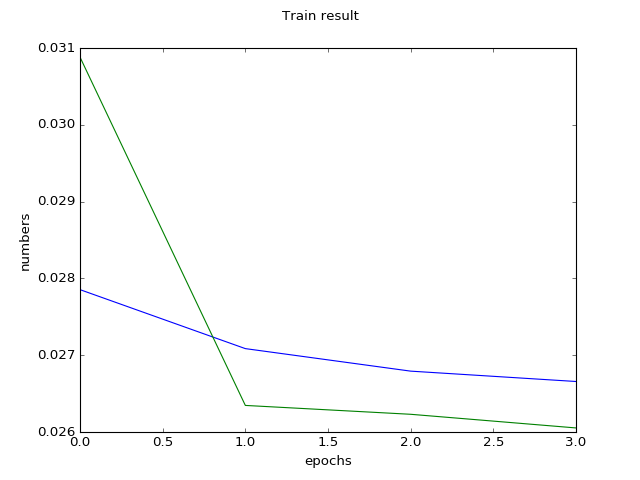

In [10]:
# plot metrics                                                       
%matplotlib notebook

plt.figure()
plt.suptitle("Train result")

# plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_acc'])
# plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['val_mean_absolute_error'])
# plt.plot(history.history['val_mean_absolute_percentage_error'])
# plt.plot(history.history['val_cosine_proximity'])

# plt.plot(history.history['loss'])
# plt.plot(history.history['acc'])

# plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
# plt.plot(history.history['mean_absolute_percentage_error'])
# plt.plot(history.history['cosine_proximity'])
                                                           
plt.xlabel("epochs")
plt.ylabel("numbers")
# plt.tight_layout()
plt.show()
                                                           

### Parameters

In [ ]:
## HAVE to use OPS PARAMS ***********
learning_rate = 0.001
# training_epochs = 80
# batch_size = 256
display_step = 1

### Network Parameters

In [ ]:
## HAVE to use NET_STRUCTURE ***********
n_input_dim = 195192.0
n_input = 1230  # data input
n_hidden_1 = 1024  # 1st layer number of neurons
n_hidden_2 = 1024  # 2nd layer number of neurons
n_hidden_3 = 1024  # 3rd layer number of neurons
n_classes = (963 + 963)  # total classes (real+imaginary)

# For checking
# train_time = np.zeros(training_epochs)

# validation_error = np.full((1), np.inf)
# min_validation_error = np.full((1), np.inf)

Best_Cost = - np.inf
Best_Weight, Best_Bias = None, None
Best_epoch = -1

# For displaying
PREVIOUS_10 = 10
DIFF_THRESHOLD = 0.000001


### Fully-Connected 3 layer Feed Forward Net

In [ ]:
X = tf.placeholder(tf.float32, shape=[None, n_input])
Y = tf.placeholder(tf.float32, shape=[None, n_classes])


# Xavier Initialization
def weight_variable(shape, stddev=None, stddev_2=None):
    if stddev is None:
        initial = tf.truncated_normal(shape, stddev=np.sqrt(2.0 / sum(shape)))
    elif stddev > 0.0:
        if stddev_2 is not None:
            r, c = shape
            initial1 = tf.truncated_normal([r, c//2], stddev=stddev)
            initial2 = tf.truncated_normal([r, c//2], stddev=stddev_2)
            initial = tf.concat([initial1,initial2], axis=1)
        else:
            initial = tf.truncated_normal(shape, stddev=stddev)

    else:
        initial = tf.constant(0.0, shape=shape)

    return tf.Variable(initial)


def bias_variable(shape, stddev=None, stddev_2=None):
    # initial = tf.constant(0.1, shape=shape)
    if stddev is None:
        initial = tf.truncated_normal(shape, stddev=np.sqrt(1.0 / sum(shape)))
    elif stddev > 0.0:
        if stddev_2 is not None:
            r, c = shape
            initial1 = tf.truncated_normal([r, c//2], stddev=stddev)
            initial2 = tf.truncated_normal([r, c//2], stddev=stddev_2)
            initial = tf.concat([initial1,initial2], axis=1)
        else:
            initial = tf.truncated_normal(shape, stddev=stddev)

    else:
        initial = tf.constant(0.0, shape=shape)

    return tf.Variable(initial)

In [ ]:
# old way
weights = {
    'h1': weight_variable([n_input, n_hidden_1],0.001),
    'h2': weight_variable([n_hidden_1, n_hidden_2],0.001),
    'h3': weight_variable([n_hidden_2, n_hidden_3],0.001),
    'out': weight_variable([n_hidden_3, n_classes],0.001,0.0)
}
biases = {
    'b1': bias_variable([1, n_hidden_1],0.0),
    'b2': bias_variable([1, n_hidden_2],0.0),
    'b3': bias_variable([1, n_hidden_3],0.0),
    'out': bias_variable([1, n_classes],0.001,0.0)
}

### Create model

In [ ]:
def multilayer_NN(x):
    layer_1 = tf.nn.relu(tf.matmul(x, weights['h1']) + biases['b1'])
    layer_2 = tf.nn.relu(tf.matmul(layer_1, weights['h2']) + biases['b2'])
    layer_3 = tf.nn.relu(tf.matmul(layer_2, weights['h3']) + biases['b3'])
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']

    return out_layer


def calc(x, y):
    # Returns predictions and error
    predictions = multilayer_NN(x)

    # Define loss and optimizer
    r, c = y.get_shape().as_list()
    r = opts.sgd_batch_size
    print('r:', type(r), r, ',c:', type(c), c)

    # TRAIN: matlab
    # cost1 = 0.5 * sum(sum((pred_real - label_real). ^ 2)) / num_sample;
    # cost2 = 0.5 * sum(sum((pred_imag - label_imag). ^ 2)) / num_sample;
    # cost = cost1 + cost2;
    cost1 = tf.reduce_sum(tf.squared_difference(y[:, :c//2], predictions[:, :c//2]))
    cost2 = tf.reduce_sum(tf.squared_difference(y[:, c//2:], predictions[:, c//2:]))
    loss_t = 0.5*(cost1+cost2)/r
    # mse = tf.losses.mean_squared_error(labels=y, predictions=predictions,weights=0.5)
    # loss_t = tf.divide(tf.reduce_sum(mse), r)


    # DEV: matlab
    # dev_perfs = -mean(sum((dev_label_real - dev_netout1). ^ 2)) - mean(sum((dev_label_imag - dev_netout2). ^ 2));
    mse_r = tf.reduce_sum(tf.squared_difference(y[:, :c // 2], predictions[:, :c // 2]), axis=0)
    mse_i = tf.reduce_sum(tf.squared_difference(y[:, c // 2:], predictions[:, c // 2:]), axis=0)

    loss_d = -tf.reduce_mean(mse_r)-tf.reduce_mean(mse_i)


    return [predictions, loss_t, mse_r, mse_i, loss_d ]

In [ ]:
def write_file(best_weights, best_biases, DNN_NET_FILE):
    W_1, W_2, W_3, W_4 = [np.array(best_weights['h1'], ndmin=2), np.array(best_weights['h2'], ndmin=2),
                          np.array(best_weights['h3'], ndmin=2), np.array([], ndmin=2)]
    W_1, W_2, W_3, W_4 = W_1.T, W_2.T, W_3.T, W_4

    print('W_1: ', W_1.shape, 'W_2: ', W_2.shape, 'W_3: ', W_3.shape, 'W_4: ', W_4.shape)

    b_1, b_2, b_3, b_4 = [np.array(best_biases['b1'], ndmin=2), np.array(best_biases['b2'], ndmin=2),
                          np.array(best_biases['b3'], ndmin=2), np.array([], ndmin=2)]
    b_1, b_2, b_3, b_4 = b_1.T, b_2.T, b_3.T, b_4

    print('b_1: ', b_1.shape, 'b_2: ', b_2.shape, 'b_3: ', b_3.shape, 'b_4: ', b_4.shape)

    Wo, bo = np.array(best_weights['out'], ndmin=2), np.array(best_biases['out'], ndmin=2)

    Wo1_1, Wo1_2, Wo1_3, Wo1_4 = [np.array([], ndmin=2), np.array([], ndmin=2), np.array([], ndmin=2), Wo[:, :963].T]
    bo1_1, bo1_2, bo1_3, bo1_4 = [np.array([], ndmin=2), np.array([], ndmin=2), np.array([], ndmin=2),
                                  bo[:, :963].T]
    # Wo1_1, Wo1_2, Wo1_3, Wo1_4 = [np.array([], ndmin=2), np.array([], ndmin=2), np.array([], ndmin=2), Wo[:963]]
    # bo1_1, bo1_2, bo1_3, bo1_4 = [np.array([],ndmin=2), np.array([],ndmin=2), np.array([],ndmin=2),
    #                               np.reshape(np.transpose(bo[:963]), (963, 1))]


    Wo2_1, Wo2_2, Wo2_3, Wo2_4 = [np.array([], ndmin=2), np.array([], ndmin=2), np.array([], ndmin=2), Wo[:, 963:].T]
    bo2_1, bo2_2, bo2_3, bo2_4 = [np.array([], ndmin=2), np.array([], ndmin=2), np.array([], ndmin=2),
                                  bo[:, 963:].T]
    # Wo2_1, Wo2_2, Wo2_3, Wo2_4 = [np.array([],ndmin=2), np.array([],ndmin=2), np.array([],ndmin=2), Wo[963:]]
    # bo2_1, bo2_2, bo2_3, bo2_4 = [np.array([],ndmin=2), np.array([],ndmin=2), np.array([],ndmin=2),
    #                               np.reshape(np.transpose(bo[963:]), (963, 1))]

    print('Wo1_1: ', Wo1_1.shape, 'Wo1_2: ', Wo1_2.shape, 'Wo1_3: ', Wo1_3.shape, 'Wo1_4: ', Wo1_4.shape)
    print('bo1_1: ', bo1_1.shape, 'bo1_2: ', bo1_2.shape, 'bo1_3: ', bo1_3.shape, 'bo1_4: ', bo1_4.shape)

    print('Wo2_1: ', Wo2_1.shape, 'Wo2_2: ', Wo2_2.shape, 'Wo2_3: ', Wo2_3.shape, 'Wo2_4: ', Wo2_4.shape)
    print('bo2_1: ', bo2_1.shape, 'bo2_2: ', bo2_2.shape, 'bo2_3: ', bo2_3.shape, 'bo2_4: ', bo2_4.shape)

    # Param_Dict = {'W': np.transpose([W_1,W_2, W_3]), 'b':np.transpose([b_1,b_2, b_3]) }
    # Param_Dict = {'W': { (W_1, W_2, (W_3)}, 'b': {(b_1), (b_2), (b_3)}}
    Param_Dict = np.core.records.fromarrays(
        [[W_1, W_2, W_3, W_4], [b_1, b_2, b_3, b_4], [Wo1_1, Wo1_2, Wo1_3, Wo1_4], [bo1_1, bo1_2, bo1_3, bo1_4],
         [Wo2_1, Wo2_2, Wo2_3, Wo2_4], [bo2_1, bo2_2, bo2_3, bo2_4]], names='W,b,Wo1,bo1,Wo2,bo2')

    # print(Param_Dict.shape, Param_Dict)
    master_dict = {'struct_net': [Param_Dict]}

    sio.savemat(DNN_NET_FILE, master_dict, format='5', long_field_names=True)

### main()

In [ ]:
# TRAIN ops
y_p, loss_op, m_r, m_i, _ = calc(X, Y)
train_op = tf.train.AdamOptimizer().minimize(loss=loss_op)


sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Training cycle

for epoch in range(opts.sgd_max_epoch):

    s = time.time()
    cost_sum = 0.0

    ##### Create Train Batch, evaluate COST, Weight, Bias #####
    ###########################################################
    for batch_num, (batch_x, batch_y) in enumerate(opts.next_batch(opts.trData.shape[0], opts.sgd_batch_size)):

        _, c, epoch_w, epoch_b  = sess.run([train_op, loss_op, weights, biases ],
                                          feed_dict={X: batch_x, Y: batch_y})
        cost_sum += c

        if batch_num % 1000 == 0:
            print('[T] - Epoch:', epoch, ', batch_num:', batch_num, ", Cost:", c, "Cost Sum:", cost_sum)

    print('[T] - Epoch:', epoch, ",Sum:", cost_sum)


    ################ Validation in whole batch ################
    ###########################################################

    avg_cost, sum_mse_r, sum_mse_i = 0.0, np.zeros(n_classes//2), np.zeros(n_classes//2)
    ##### Create DEV Batch, evaluate COST, Weight, Bias #####
    ###########################################################
    for batch_num, (batch_x, batch_y) in enumerate(opts.next_batch(opts.cvData.shape[0], opts.sgd_batch_size, isTrainCycle=False)):

        mse_r, mse_i = sess.run([m_r, m_i], feed_dict={X: batch_x, Y: batch_y})
        # print(sum_mse_r.shape, mse_r.shape, mse_i.shape)
        sum_mse_r += (mse_r)
        sum_mse_i += (mse_i)

    avg_cost = - np.mean(sum_mse_r) - np.mean(sum_mse_i)
    # print('[D] - Epoch:', epoch, ", Mean Real:", - np.mean(sum_mse_r), ", Mean Img:" , - np.mean(sum_mse_i), ", Avg Cost:", avg_cost)

    print("[D] - Epoch:{0}, Avg Cost:{1:.5f}, Real(mean,var):({2:.5f},{3:.5f}), Img(mean,var):({4:.5f},{5:.5f})".format( epoch,avg_cost, -np.mean(sum_mse_r),-np.var(sum_mse_r), -np.mean(sum_mse_i),
          -np.var(sum_mse_i)) )

    ####### Min validation error, update weights, bias #########
    ############################################################


    if avg_cost > Best_Cost:
        Best_Cost = avg_cost
        Best_Weight = epoch_w
        Best_Bias = epoch_b
        Best_epoch = epoch

        print('***** [D] - Best Model at Epoch:', epoch, ", Avg Cost:", avg_cost, '*****')


    ######################  Write Model File ###################
    ############################################################

    print('[] - Elapsed Time: {0:.2f}(s), {1:.2f}(min)'.format( time.time()-s, (time.time()-s)/60 ) )

In [ ]:
# Training DONE !!!
print("Optimization Finished!")
print('***** [-] - Best Model at Epoch:', Best_epoch, ", Best Val Cost:", Best_Cost, '*****')
write_file(Best_Weight, Best_Bias, DNN_NET_FILE)
print(" File Write complete")
